# 大作业: 四旋翼无人机控制
PB20061372 朱云沁

In [1]:
import numpy as np
from sympy import *
from sympy.abc import t, s
import control

import matplotlib as mpl
import matplotlib.pyplot as plt

mpl.rcParams['mathtext.fontset'] = 'cm'
mpl.rcParams['font.size'] = 8
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['lines.linewidth'] = 0.8
mpl.rcParams['lines.markerfacecolor'] = 'none'

### 问题描述

In [2]:
# 固定参数
m, g, k_x, k_y, k_z, k_p, k_q, k_r, I_x, I_y, I_z, z_d, psi_d = symbols(
    'm g k_x k_y k_z k_p k_q k_r I_x I_y I_z z_d psi_d')
params = {
    m:      0.03,       # 质量
    g:      9.81,       # 重力加速度
    k_x:    4.5e-3,     # 阻力系数 x 分量
    k_y:    4.5e-3,     # 阻力系数 y 分量
    k_z:    4.5e-3,     # 阻力系数 z 分量
    k_p:    4.5e-4,     # 阻力矩系数 p 分量
    k_q:    4.5e-4,     # 阻力矩系数 q 分量
    k_r:    4.5e-4,     # 阻力矩系数 r 分量
    I_x:    1.5e-5,     # 转动惯量 x 分量
    I_y:    1.5e-5,     # 转动惯量 y 分量
    I_z:    3e-5,       # 转动惯量 z 分量
    z_d:    2,          # 初始 z 坐标 (悬停高度)
    psi_d:  0.25 * pi,  # 初始偏航角
}

Matrix(list(params.keys())).T

Matrix([[m, g, k_x, k_y, k_z, k_p, k_q, k_r, I_x, I_y, I_z, z_d, psi_d]])

In [3]:
# 状态向量
x, y, Deltaz, xdot, ydot, zdot, phi, theta, Deltapsi, p, q, r = symbols(
    'x y Δz xdot ydot zdot phi theta Δψ p q r')
X = Matrix([x, y, Deltaz, xdot, ydot, zdot, phi, theta, Deltapsi, p, q, r])

# 初始状态
initial_state = {
    x:          0,
    y:          0,
    Deltaz:     0,
    xdot:       0,
    ydot:       0,
    zdot:       0,
    phi:        0,
    theta:      0,
    Deltapsi:   0,
    p:          0,
    q:          0,
    r:          0,
}


X.T

Matrix([[x, y, Δz, xdot, ydot, zdot, phi, theta, Δψ, p, q, r]])

In [4]:
# 输入向量
Deltau_1, u_2, u_3, u_4 = symbols('Δu_1 u_2 u_3 u_4')
U = Matrix([Deltau_1, u_2, u_3, u_4])

U.T

Matrix([[Δu_1, u_2, u_3, u_4]])

In [5]:
# 输出向量
Y = Matrix([x, y, Deltaz, Deltapsi])

Y.T

Matrix([[x, y, Δz, Δψ]])

In [6]:
# 系统矩阵
A = zeros(12, 12)
A[0, 3] = A[1, 4] = A[2, 5] = 1
A[6, 9] = A[7, 10] = A[8, 11] = 1
A[3, 6], A[3, 7] = g * sin(psi_d), g * cos(psi_d)
A[4, 6], A[4, 7] = -g * cos(psi_d), g * sin(psi_d)
A[3, 3], A[4, 4], A[5, 5] = -k_x / m, -k_y / m, -k_z / m
A[9, 9], A[10, 10], A[11, 11] = -k_p / I_x, -k_q / I_y, -k_r / I_z

A

Matrix([
[0, 0, 0,      1,      0,      0,             0,            0, 0,        0,        0,        0],
[0, 0, 0,      0,      1,      0,             0,            0, 0,        0,        0,        0],
[0, 0, 0,      0,      0,      1,             0,            0, 0,        0,        0,        0],
[0, 0, 0, -k_x/m,      0,      0,  g*sin(psi_d), g*cos(psi_d), 0,        0,        0,        0],
[0, 0, 0,      0, -k_y/m,      0, -g*cos(psi_d), g*sin(psi_d), 0,        0,        0,        0],
[0, 0, 0,      0,      0, -k_z/m,             0,            0, 0,        0,        0,        0],
[0, 0, 0,      0,      0,      0,             0,            0, 0,        1,        0,        0],
[0, 0, 0,      0,      0,      0,             0,            0, 0,        0,        1,        0],
[0, 0, 0,      0,      0,      0,             0,            0, 0,        0,        0,        1],
[0, 0, 0,      0,      0,      0,             0,            0, 0, -k_p/I_x,        0,        0],
[0, 0, 0,      0,    

In [7]:
# 输入矩阵
B = zeros(12, 4)
B[5, 0] = 1 / m
B[9, 1], B[10, 2], B[11, 3] = 1 / I_x, 1 / I_y, 1 / I_z

B

Matrix([
[  0,     0,     0,     0],
[  0,     0,     0,     0],
[  0,     0,     0,     0],
[  0,     0,     0,     0],
[  0,     0,     0,     0],
[1/m,     0,     0,     0],
[  0,     0,     0,     0],
[  0,     0,     0,     0],
[  0,     0,     0,     0],
[  0, 1/I_x,     0,     0],
[  0,     0, 1/I_y,     0],
[  0,     0,     0, 1/I_z]])

In [8]:
# 输出矩阵
C = zeros(4, 12)
C[0, 0] = C[1, 1] = C[2, 2] = C[3, 8] = 1

C

Matrix([
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
[0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0]])

## P1

In [9]:
# 系统矩阵的特征值
eigenvals = A.subs(params).eigenvals()
print(eigenvals)

# 判断系统的稳定性
if all([re(eigenval) < 0 for eigenval in eigenvals]):
    print('系统稳定')
else:
    print('系统不稳定')

{0: 6, -0.150000000000000: 3, -30.0000000000000: 2, -15.0000000000000: 1}
系统不稳定


## P2

- 高度控制子系统
$$
\ddot{z} = -\frac{k_z}{m}\dot{z} + \frac{1}{m}\Delta u_1
$$

$$
G_z(s) = \frac{\frac{1}{m}}{s^2 + \frac{k_z}{m}s}
$$

- 偏航角控制子系统
$$
\ddot{\psi} = -\frac{k_r}{I_z}\dot{\psi} + \frac{1}{I_z} u_4
$$

$$
G_\psi(s) = \frac{\frac{1}{I_z}}{s^2 + \frac{k_r}{I_z}s}
$$

In [10]:
G_z = 1 / m / (s**2 + k_z / m * s)
G_psi = 1 / I_z / (s**2 + k_r / I_z * s)

## P3

TransferFunction(array([33333.33333333]), array([ 1., 15.,  0.]))

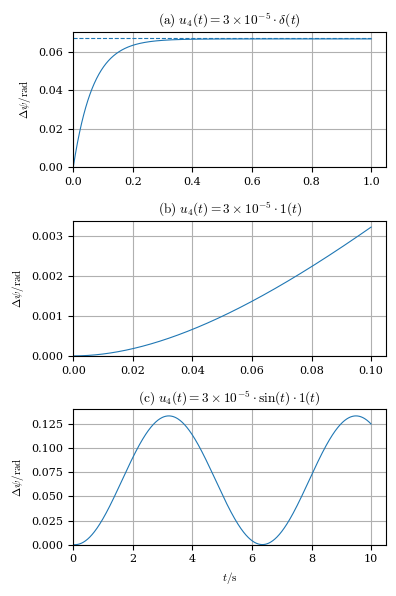

In [11]:
def plot_response(T, yout, ax=None):
    if ax is None:
        ax = plt.gca()
    ax.plot(T, yout)
    ax.set_xlim(left=0)
    ax.grid(True)


def sympy_to_control(G, s=s):
    num, den = fraction(G)
    num = np.array(Poly(num, s).all_coeffs(), dtype=float)
    den = np.array(Poly(den, s).all_coeffs(), dtype=float)
    return control.tf(num, den)

# 偏航角传递函数
sys = sympy_to_control(G_psi.subs(params))
display(sys)

fig, ax = plt.subplots(3, 1, figsize=(4, 6))

# 脉冲输入
T = np.linspace(0, 1, 1000)
T, yout = control.impulse_response(sys, T)
plot_response(T, 3e-5 * yout, ax[0])
ax[0].hlines(0.067, 0, 1, linestyles='dashed')

# 阶跃输入
T = np.linspace(0, 0.1, 1000)
T, yout = control.step_response(sys, T)
plot_response(T, 3e-5 * yout, ax[1])

# 正弦输入
T = np.linspace(0, 10, 1000)
T, yout = control.forced_response(sys, T, U=np.sin(T))
plot_response(T, 3e-5 * yout, ax[2])
ax[2].set_xlabel(r'$t / \rm{s}$')

titles = [
    r'$\mathrm{(a)}\ u_4(t) = 3 \times 10^{-5} \cdot \delta(t)$',
    r'$\mathrm{(b)}\ u_4(t) = 3 \times 10^{-5} \cdot 1(t)$',
    r'$\mathrm{(c)}\ u_4(t) = 3 \times 10^{-5} \cdot \sin(t) \cdot 1(t)$'
]

for ax, title in zip(ax, titles):
    ax.set_ylim(bottom=0)
    ax.set_ylabel(r'$\Delta\psi / \rm{rad}$')
    ax.set_title(title)

fig.tight_layout()
fig.savefig('figs/p3.svg')

脉冲输入下的稳态响应
$$
\Delta\psi(\infty) = \lim_{s\to 0} sG_\psi U_4(s) = \lim_{s\to 0} \frac{1}{s + 15} \approx 0.067
$$

## P4

$$
\Delta Z(s) = \frac{s + \frac{k_z}{m}}{s^2 + \frac{k_z}{m}s + \frac{k}{m}}\Delta z(0)
$$

33.3333333333333/(s**2 + 0.15*s)

k = 0.01 振荡
k = 0.001 振荡
k = 0.0002 振荡


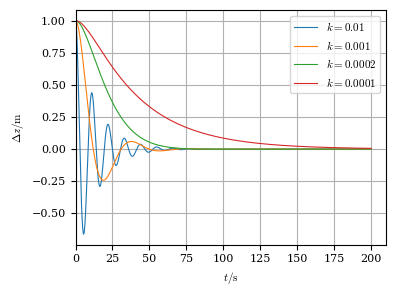

In [12]:
# 高度传递函数
tf = G_z.subs(params)
display(tf)

# 初始状态
Deltaz_0 = 1


def plot_p4(k):
    # 比例控制器
    ctr = k
    # 闭环传递函数
    tfc = simplify(ctr * tf / (1 + ctr * tf))

    sys = sympy_to_control(tfc)
    sys = control.tf2ss(sys)
    X_0 = np.linalg.solve(control.obsv(sys.A, sys.C), [Deltaz_0, 0])

    T = np.linspace(0, 200, 1000)
    T, yout = control.initial_response(sys, T, X0=X_0)
    plot_response(T, yout)
    if np.min(yout) < 0:
        print(f'k = {k} 振荡')


plt.figure(figsize=(4, 3))

k_list = [0.01, 0.001, 0.0002, 0.0001]
for k in k_list:
    plot_p4(k)

plt.legend([f'$k = {k}$' for k in k_list])
plt.xlabel(r'$t / \rm{s}$')
plt.ylabel(r'$\Delta z / \rm{m}$')
plt.tight_layout()
plt.savefig('figs/p4.svg')

$$
\Delta Z(s) = \frac{s + 0.15}{s^2 + 0.15s + \frac{100k}{3}}
$$
稳态响应 $\Delta z(\infty) = \lim_{s\to 0} s\Delta Z (s) = 0$

高度响应振荡当且仅当 $\Delta Z(s)$ 存在共轭极点, 即
$$
0.15^2 - 4\frac{100k}{3} < 0
$$
解得 $k > 0.00019625$

## P5

$$
G_c(s) = \frac{(2-Ts)K(s)}{ms^2(2+Ts) + (2-Ts)K(s)}
$$

In [13]:
Td, k_P, k_D, T_D, p_I = symbols('T k_p k_d T_d p_i', positive=True)
# PD 控制器
K = k_P + k_D * s
# 开环传递函数
G_o = simplify(K * G_z * (2 - Td * s) / (2 + Td * s))
# 闭环传递函数
G_c = simplify(G_o / (1 + G_o))
num, den = fraction(G_c)
num, den = Poly(num, s), Poly(den, s)
G_c = num / den

display(G_o, G_c)

-(T*s - 2)*(k_d*s + k_p)/(s*(k_z + m*s)*(T*s + 2))

(-T*k_d*s**2 + 2*k_p + s*(-T*k_p + 2*k_d))/(T*m*s**3 + 2*k_p + s**2*(-T*k_d + T*k_z + 2*m) + s*(-T*k_p + 2*k_d + 2*k_z))

In [14]:
# 特征多项式
poly = Poly(den.subs({m: 0.03, k_z: 0, Td: 1e-3}), s)
poly

Poly(3.0e-5*s**3 + (0.06 - 0.001*k_d)*s**2 + (2.0*k_d - 0.001*k_p)*s + 2.0*k_p, s, domain='RR[k_d,k_p]')

In [15]:
# 劳斯阵列
def routh_tableau(coef):
    N = len(coef)
    A = zeros(N)
    for i in range(N):
        A[i % 2, i // 2] = coef[i]

    for i in range(2, N):
        for j in range(0, N - i):
            A[i, j] += A[i - 1, 0] * A[i - 2, j + 1]
            A[i, j] -= A[i - 2, 0] * A[i - 1, j + 1]
            if A[i - 1, 0] != 0:
                A[i, j] /= A[i - 1, 0]

    return A


routh_tableau(poly.all_coeffs())

Matrix([
[                                                                     3.0e-5, 2.0*k_d - 0.001*k_p, 0, 0],
[                                                           0.06 - 0.001*k_d,             2.0*k_p, 0, 0],
[(-6.0e-5*k_p + (0.06 - 0.001*k_d)*(2.0*k_d - 0.001*k_p))/(0.06 - 0.001*k_d),                   0, 0, 0],
[                                                                    2.0*k_p,                   0, 0, 0]])

闭环系统稳定当且仅当

$$
\begin{gathered}
60 - k_d > 0 \\
60k_p + (k_d - 60)(2000k_d - k_p) > 0 \\
2k_p > 0
\end{gathered}
$$

解得 $0 < k_d < 60$ 且 $0 < k_p < 2000\times\frac{k_d(k_d - 60)}{k_d - 120}$


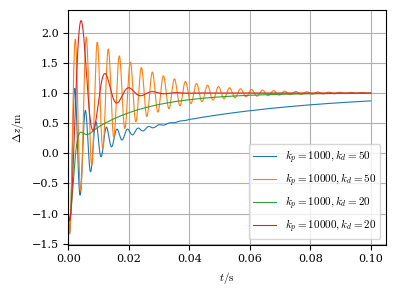

In [16]:
# 初始输出为 -1, 各阶导数为 0; 阶跃参考输入
def plot_p5(k_p, k_d):
    sys = sympy_to_control(
        G_c.subs({
            m: 0.03,
            k_z: 0,
            Td: 1e-3,
            k_P: k_p,
            k_D: k_d
        }))
    sys = control.tf2ss(sys)
    X_0 = np.linalg.solve(control.obsv(sys.A, sys.C), [-1, 0, 0])

    T = np.linspace(0, 0.1, 1000)
    T, yout = control.step_response(sys, T, X0=X_0)
    plot_response(T, yout)


plt.figure(figsize=(4, 3))

k_list = [(1000, 50), (10000, 50), (1000, 20), (10000, 20)]
labels = []
for k_p, k_d in k_list:
    plot_p5(k_p, k_d)
    labels.append(f'$k_p = {k_p}, k_d = {k_d}$')

plt.legend(labels)
plt.xlabel(r'$t / \rm{s}$')
plt.ylabel(r'$\Delta z / \rm{m}$')
plt.tight_layout()
plt.savefig('figs/p5.svg')

## P6

In [17]:
# PD 控制器: 开环传递函数
G_PD = k_P * (T_D * s + 1) * G_z
# PI 控制器: 开环传递函数
G_PI = k_P * (s + p_I) / s * G_z

display(G_PD, G_PI)

k_p*(T_d*s + 1)/(m*(k_z*s/m + s**2))

k_p*(p_i + s)/(m*s*(k_z*s/m + s**2))

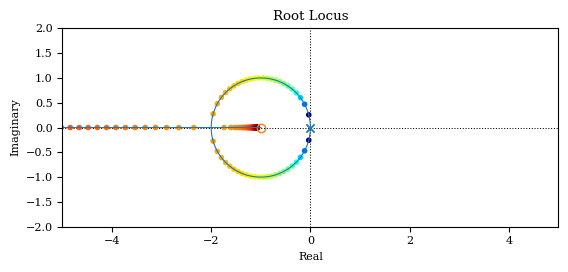

In [18]:
k_list = np.linspace(0.002, 0.5, 100)
sys = sympy_to_control(G_PD.subs({k_P: 1, m: 0.03, k_z: 0, T_D: 1}))
control.root_locus(sys, xlim=(-5, 5), ylim=(-2, 2), grid=False)
r_list, k_list = control.root_locus(sys, kvect=k_list, plot=False)
for i in range(r_list.shape[1]):
    plt.scatter(r_list[:, i].real,
                r_list[:, i].imag,
                c=np.log(k_list),
                cmap="jet",
                marker='.')
plt.gca().set_aspect('equal')

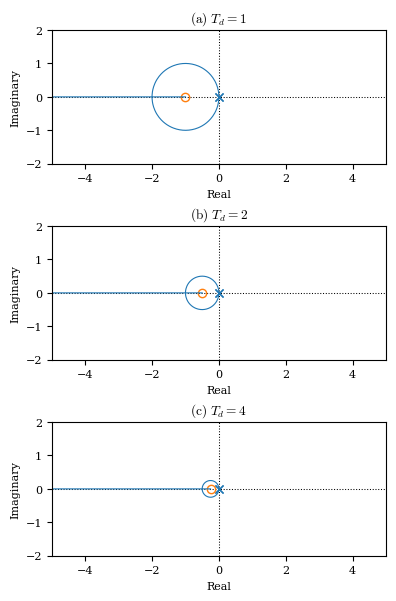

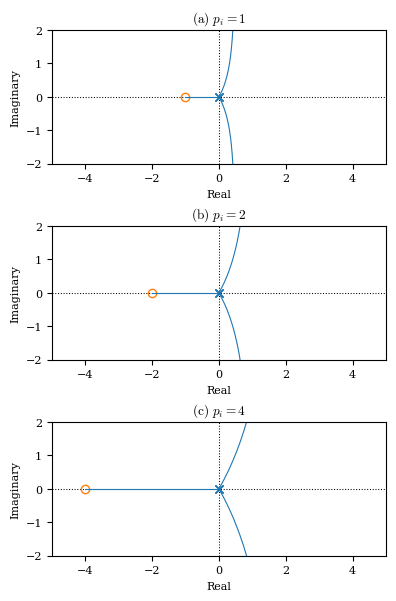

In [19]:
def plot_p6(G, param):
    fig, ax = plt.subplots(3, 1, figsize=(4, 6))
    for i, val in enumerate([1, 2, 4]):
        L = G.subs({k_P: 1, m: 0.03, k_z: 0, param: val})
        sys = sympy_to_control(L)
        control.root_locus(sys,
                           xlim=(-5, 5),
                           ylim=(-2, 2),
                           grid=False,
                           ax=ax[i])
        # k_list = np.linspace(0.002, 0.5, 50)
        # r_list, k_list = control.root_locus(sys, kvect=k_list, plot=False)
        # for j in range(r_list.shape[1]):
        #     ax[i].scatter(r_list[:, j].real,
        #                   r_list[:, j].imag,
        #                   c=np.log(k_list),
        #                   cmap="jet",
        #                   marker='.')
        ax[i].set_title(None)
        ax[i].set_aspect(1)

    return fig, ax


# PD 控制器: 根轨迹
fig, ax = plot_p6(G_PD, T_D)
titles = [
    r'$\mathrm{(a)}\ T_d = 1$', r'$\mathrm{(b)}\ T_d = 2$',
    r'$\mathrm{(c)}\ T_d = 4$'
]
for i in range(3):
    ax[i].set_title(titles[i])
fig.tight_layout()
fig.savefig('figs/p6-pd.svg')

# PI 控制器: 根轨迹
fig, ax = plot_p6(G_PI, p_I)
titles = [
    r'$\mathrm{(a)}\ p_i = 1$', r'$\mathrm{(b)}\ p_i = 2$',
    r'$\mathrm{(c)}\ p_i = 4$'
]
for i in range(3):
    ax[i].set_title(titles[i])
fig.tight_layout()
fig.savefig('figs/p6-pi.svg')


- PD 控制器: 当 $k_p > 0$, 闭环系统的 2 个极点均位于左半平面, 系统稳定.
- PI 控制器: 存在右半平面的根轨迹分支, 无法使闭环系统稳定.

## P7

(inf, 58.4459354569172, nan, 1.2656217128077616)
(inf, 80.49108628026727, nan, 2.0529883967587823)
(inf, 88.57301772183234, nan, 4.0049774959552416)


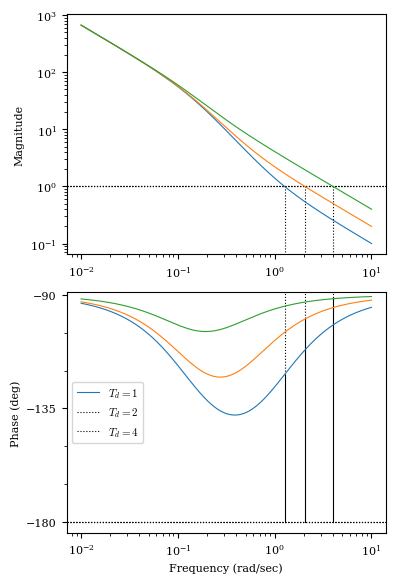

In [20]:
plt.figure(figsize=(4, 6))

for i, val in enumerate([1, 2, 4]):
    L = G_PD.subs({k_P: 0.03, m: 0.03, k_z: 4.5e-3, T_D: val})
    sys = sympy_to_control(L)
    _ = control.bode(sys, omega_limits=(1e-2, 1e1), margins=True)
    print(control.margin(sys))

labels = [r'$T_d = 1$', r'$T_d = 2$', r'$T_d = 4$']
plt.legend(labels)
plt.suptitle(None)
plt.tight_layout()
plt.savefig('figs/p7.svg')

增益裕度为无穷. 相位裕度随 $T_d$ 的增大而增大.

## P8

$$
G_x(s) = \begin{bmatrix}
1 & 0 & 0
\end{bmatrix} \left(sI - \begin{bmatrix}
0 & 1 & 0 \\
0 & -\frac{k_x}{m} & g \\
0 & 0 & 0 
\end{bmatrix}\right)^{-1} \begin{bmatrix}
0 \\ 0 \\ 1
\end{bmatrix}
= \frac{g}{s^2(s+\frac{k_x}{m})}
$$

In [21]:
# 传递函数
G_x = g / (s**2 * (s + k_x / m))
G_x

g/(s**2*(k_x/m + s))

In [22]:
# 超前补偿器
k, alpha, Td = symbols('k alpha T', positive=True)
K = k * (Td * s + 1) / (alpha * Td * s + 1)
K

k*(T*s + 1)/(T*alpha*s + 1)

In [23]:
# 特征多项式
tf = G_x.subs(params) * K
tf = simplify(tf / (1 + tf))
poly = Poly(denom(tf), s)
display(poly)

Poly(1.0*T*alpha*s**4 + (0.15*T*alpha + 1.0)*s**3 + 0.15*s**2 + 9.81*T*k*s + 9.81*k, s, domain='RR[k,T,alpha]')

In [24]:
# 劳斯阵列
A = routh_tableau(poly.all_coeffs())
for i in range(1, 5):
    num, den = fraction(A[i, 0])
    num, den = Poly(simplify(num), k), Poly(simplify(den), k)
    A[i, 0] = num / den

A

Matrix([
[                                                                                                                                                  1.0*T*alpha,     0.15, 9.81*k, 0, 0],
[                                                                                                                                           0.15*T*alpha + 1.0, 9.81*T*k,      0, 0, 0],
[                                                                                            (-9.81*T**2*alpha*k + 0.0225*T*alpha + 0.15)/(0.15*T*alpha + 1.0),   9.81*k,      0, 0, 0],
[(-96.2361*T**3*alpha*k**2 + k*(-0.220725*T**2*alpha**2 + 0.220725*T**2*alpha - 2.943*T*alpha + 1.4715*T - 9.81))/(-9.81*T**2*alpha*k + 0.0225*T*alpha + 0.15),        0,      0, 0, 0],
[                                                                                                                                                       9.81*k,        0,      0, 0, 0]])

闭环系统稳定当且仅当
$$
\begin{gathered}
T > \frac{1}{0.15(1-\alpha)} \\
k < \frac{0.15(0.15T\alpha+1)}{9.81T^2\alpha} \\
k < \frac{(0.15T(1-\alpha)-1)(0.15T\alpha+1)}{9.81T^3\alpha}
\end{gathered}
$$

In [25]:
def k_max_p8(Td, alpha):
    tmp = (0.15 * Td * alpha + 1) / (9.81 * Td**2 * alpha)
    k1 = 0.15 * tmp
    k2 = (0.15 * Td * (1 - alpha) - 1) / Td * tmp
    print(f'k1 = {k1}, k2 = {k2}')
    return min(k1, k2)


k_max_p8(100, 0.1)


k1 = 3.822629969418961e-05, k2 = 3.1855249745158005e-05


3.1855249745158005e-05

对阶跃参考信号的稳态跟踪误差
$$
e_{\rm ss} = \lim_{s\to 0} \frac{1}{1 + KG_x(s)} = 0
$$



(inf, -85.98854221598447, nan, 2.138952983872492)


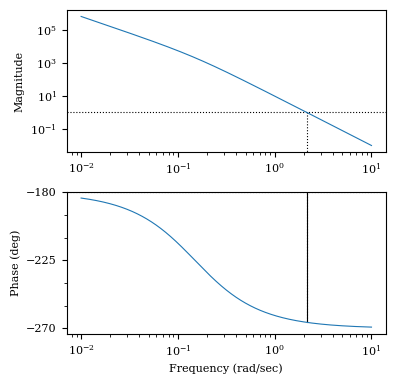

In [26]:
# 开环系统
def sys_p89(G, args={k: 1, Td: 1, alpha: 1}):
    tf = G.subs(params) * K.subs(args)
    sys = sympy_to_control(tf)
    sysc = sympy_to_control(simplify(tf / (1 + tf)))
    return sys, sysc


# Bode 图
def plot_p89_bode(sys):
    plt.figure(figsize=(4, 4))
    print(control.margin(sys))
    _ = control.bode(sys, omega_limits=(1e-2, 1e1), margins=True)
    plt.suptitle(None)


# 阶跃响应
def plot_p89_response(sys, T, ref, zero_state=False, ax=None):
    if ax is None:
        plt.figure(figsize=(4, 3))
    sys = control.tf2ss(sys)
    x_0 = np.zeros(sys.A.shape[0])
    if not zero_state:
        x_0[0] = 1
    X_0 = np.linalg.solve(control.obsv(sys.A, sys.C), x_0)

    T, yout = control.forced_response(sys, T, U=ref, X0=X_0)
    plot_response(T, yout, ax=ax)
    if ax is None:
        plt.xlabel(r'$t / \rm{s}$')
        plt.ylabel(r'$x / \rm{m}$')


# 无补偿
sys, _ = sys_p89(G_x)
# Bode 图
plot_p89_bode(sys)
plt.tight_layout()
plt.savefig('figs/p8-bode0.svg')

(10.618416581719327, 44.713879556118826, 0.11180339887498945, 0.021049460008284827)
{'RiseTime': 48.73044886090594, 'SettlingTime': 292.3826931654357, 'SettlingMin': 0.9263786605094678, 'SettlingMax': 1.338164195343148, 'Overshoot': 33.816419534314804, 'Undershoot': 0, 'Peak': 1.338164195343148, 'PeakTime': 135.93230471726395, 'SteadyStateValue': 1.0}


<Figure size 640x480 with 0 Axes>

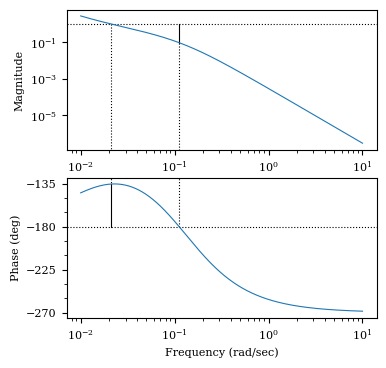

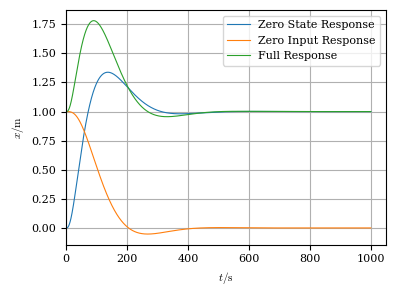

In [27]:
# 有补偿
sys, sysc = sys_p89(G_x, {k: 3e-6, Td: 100, alpha: 0.1})
# Bode 图
plt.tight_layout()
plot_p89_bode(sys)
plt.savefig('figs/p8-bode.svg')

T = np.linspace(0, 1e3, 10000)
fig, ax = plt.subplots(figsize=(4, 3))
# 零状态响应
plot_p89_response(sysc, T, np.ones_like(T), zero_state=True, ax=ax)
# 零输入响应
plot_p89_response(sysc, T, np.zeros_like(T), ax=ax)
# 全响应
plot_p89_response(sysc, T, np.ones_like(T), ax=ax)

plt.xlabel(r'$t / \rm{s}$')
plt.ylabel(r'$x / \rm{m}$')
plt.legend([r'Zero State Response', r'Zero Input Response', r'Full Response'])
plt.tight_layout()
plt.savefig('figs/p8-resp.svg')

# 计算超调量, 上升时间等
print(control.step_info(sysc))

## P9

$$
\frac{\mathrm{d}}{\mathrm{d} t} \begin{bmatrix}
x \\ \dot{x}
\end{bmatrix} = \begin{bmatrix}
0 & 1 \\
0 & -\frac{k_x}{m}
\end{bmatrix} \begin{bmatrix}
x \\ \dot{x}
\end{bmatrix} + \begin{bmatrix}
0 \\ g
\end{bmatrix} \theta
$$

$$
G_x(s) = \begin{bmatrix}
1 & 0
\end{bmatrix} \left(sI - \begin{bmatrix}
0 & 1 \\
0 & -\frac{k_x}{m} \\
\end{bmatrix}\right)^{-1} \begin{bmatrix}
0 \\ g
\end{bmatrix}
= \frac{g}{s(s+\frac{k_x}{m})}
$$

$$
G_{\mathrm{out}}(s) = \frac{\frac{5}{s}}{1+\frac{5}{s}} G_x(s) = \frac{5g}{s(s+5)(s+\frac{k_x}{m})}
$$

In [28]:
# 传递函数
G_out = 5 * g / (s * (s + 5) * (s + k_x / m))
G_out

5*g/(s*(s + 5)*(k_x/m + s))

In [29]:
# 特征多项式
tf = G_out.subs(params) * K
tf = simplify(tf / (1 + tf))
poly = Poly(denom(tf), s)
display(poly)

Poly(1.0*T*alpha*s**4 + (5.15*T*alpha + 1.0)*s**3 + (0.75*T*alpha + 5.15)*s**2 + (49.05*T*k + 0.75)*s + 49.05*k, s, domain='RR[k,T,alpha]')

In [30]:
# 劳斯阵列
A = routh_tableau(poly.all_coeffs())
for i in range(1, 5):
    num, den = fraction(A[i, 0])
    num, den = Poly(simplify(num), k), Poly(simplify(den), k)
    A[i, 0] = num / den

A

Matrix([
[                                                                                                                                                                                                                                                                       1.0*T*alpha, 0.75*T*alpha + 5.15, 49.05*k, 0, 0],
[                                                                                                                                                                                                                                                                5.15*T*alpha + 1.0,    49.05*T*k + 0.75,       0, 0, 0],
[                                                                                                                                                                                         (3.8625*T**2*alpha**2 - 49.05*T**2*alpha*k + 26.5225*T*alpha + 5.15)/(5.15*T*alpha + 1.0),             49.05*k,       0, 0, 0],
[(-2405.9025*T**3*alpha*k**2 + 2.896875*T**2*alph

In [31]:
solve(Poly(numer(A[2, 0]), k).subs({Td: 2, alpha: 0.1}) > 0)

k < 0.54072375127421

In [32]:
solve(Poly(numer(A[3, 0]), k).subs({Td: 2, alpha: 0.1}) > 0)

k < 0.437509529180749

In [33]:
Poly(simplify(numer(A[3, 0])), k)

Poly(-2405.9025*T**3*alpha*k**2 + (189.455625*T**3*alpha**2 - 1300.928625*T**2*alpha**2 + 1264.141125*T**2*alpha - 505.215*T*alpha + 252.6075*T - 49.05)*k + 2.896875*T**2*alpha**2 + 19.891875*T*alpha + 3.8625, k, domain='RR[T,alpha]')

闭环系统稳定当且仅当
$$
k < \frac{3.8625T^2\alpha^2 + 26.5225T\alpha + 5.15}{49.05T^2\alpha} \\
\vdots
$$
过于复杂, 略.

对阶跃参考信号的稳态跟踪误差
$$
e_{\rm ss} = \lim_{s\to 0} \frac{1}{1 + K_{\mathrm{out}}G_{\mathrm{out}}(s)} = 0
$$



(0.07874617737003062, -27.247523178510846, 0.8660254037844388, 2.909884781023379)


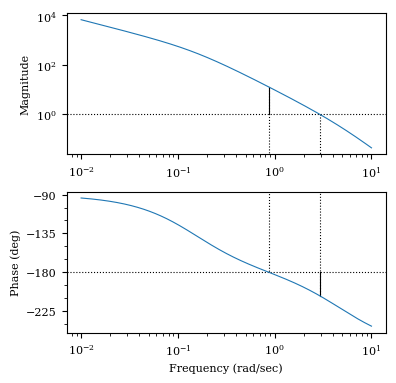

In [34]:
# 无补偿
sys, _ = sys_p89(G_out)
# Bode 图
plot_p89_bode(sys)
plt.tight_layout()
plt.savefig('figs/p9-bode0.svg')

(5.468869114759366, 43.76687466028042, 4.638120309589049, 1.508245252732591)
{'RiseTime': 0.7033958620247356, 'SettlingTime': 3.726096998833734, 'SettlingMin': 0.9062914203126915, 'SettlingMax': 1.3093394655687576, 'Overshoot': 30.933946556875757, 'Undershoot': 0, 'Peak': 1.3093394655687576, 'PeakTime': 1.863048499416867, 'SteadyStateValue': 1.0}


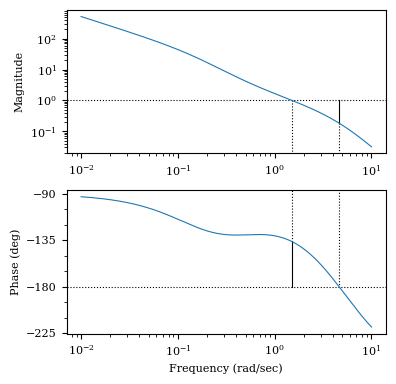

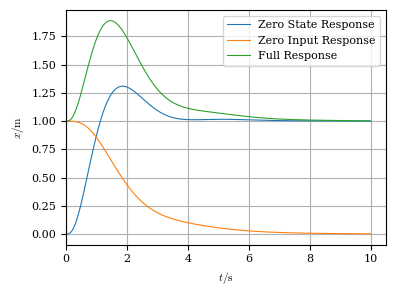

In [35]:
# 有补偿
sys, sysc = sys_p89(G_out, {k: 0.08, Td: 2, alpha: 0.1})
# Bode 图
plot_p89_bode(sys)
plt.tight_layout()
plt.savefig('figs/p9-bode.svg')

T = np.linspace(0, 10, 1000)
fig, ax = plt.subplots(figsize=(4, 3))
# 零状态响应
plot_p89_response(sysc, T, np.ones_like(T), zero_state=True, ax=ax)
# 零输入响应
plot_p89_response(sysc, T, np.zeros_like(T), ax=ax)
# 全响应
plot_p89_response(sysc, T, np.ones_like(T), ax=ax)

plt.xlabel(r'$t / \rm{s}$')
plt.ylabel(r'$x / \rm{m}$')
plt.legend([r'Zero State Response', r'Zero Input Response', r'Full Response'])
plt.tight_layout()
plt.savefig('figs/p9-resp.svg')

# 计算超调量, 上升时间等
print(control.step_info(sysc))